<a href="https://colab.research.google.com/github/frederik-kilpinen/ASDS2/blob/main/Notebooks/exhaustive_topic_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install nltk==3.4

In [2]:
#Importing erlevant packages 
import numpy as np
import pandas as pd
from datetime import datetime 
from tqdm import tqdm 
import logging 
import sys 
import pickle 
import requests
import io

#Importing NLTK and NLP packages
import nltk
from nltk.tokenize import TweetTokenizer
import string
import re
from collections import defaultdict

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Importing and viewing data
tweets = pd.read_csv("/content/drive/MyDrive/Digital methods/final_tweet_df")

In [4]:
# Subsetting data (should be removed with new dataset)
tweets.loc[(tweets["created_at"] >= "2018-06-01") & (tweets["created_at"] <= "2021-05-01")]

,Unnamed: 0,screen_name,m.uid,tweet_id,created_at,full_text,favorite_count,retweet_count,in_reply_to_screen_name,hashtags,user_mentions,url,image_url,p.country,m.name,p.party,lp.official_legislative_period
16,16,AlanTudgeMP,185932331,1.388304e+18,2021-05-01,My further thoughts on the draft national curr...,5.0,1.0,AlanTudgeMP,[],[],https://www.theaustralian.com.au/inquirer/get-...,NaN,Australia,Alan Tudge,Liberal Party of Australia,46
17,17,AlanTudgeMP,185932331,1.388304e+18,2021-05-01,The Age headline on their front page is mislea...,19.0,1.0,NaN,[],[],NaN,NaN,Australia,Alan Tudge,Liberal Party of Australia,46
18,18,AlanTudgeMP,185932331,1.388275e+18,2021-04-30,Get the fundamentals right and lift our game. ...,18.0,7.0,NaN,[],[],https://www.theaustralian.com.au/inquirer/get-...,NaN,Australia,Alan Tudge,Liberal Party of Australia,46
19,19,AlanTudgeMP,185932331,1.388274e+18,2021-04-30,RT @australian: State and federal education mi...,0.0,6.0,NaN,[],['australian'],NaN,NaN,Australia,Alan Tudge,Liberal Party of Australia,46
20,20,AlanTudgeMP,185932331,1.388039e+18,2021-04-30,Great support for our $53m Higher Education su...,12.0,3.0,NaN,[],[],https://twitter.com/ITECAust/status/1387941814...,NaN,Australia,Alan Tudge,Liberal Party of Australia,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299035,299035,P_Thompson88,929896339307053056,1.260309e+18,2020-05-12,REEF HQ FUNDING BOOST: We've just announced $2...,7.0,0.0,NaN,[],['reefhqaquarium'],https://www.philthompson.com.au/media-release-...,NaN,Australia,Phillip Thompson,Liberal National Party of Queensland,46
299036,299036,P_Thompson88,929896339307053056,1.260183e+18,2020-05-12,We've been doing so well at keeping COVID-19 a...,3.0,0.0,NaN,['TownsvilleStrong'],[],https://www.philthompson.com.au/media-release-...,NaN,Australia,Phillip Thompson,Liberal National Party of Queensland,46
299037,299037,P_Thompson88,929896339307053056,1.260103e+18,2020-05-12,JOBKEEPER Q&amp;A: I've asked Assistant Treasu...,2.0,0.0,NaN,[],[],http://philthompson.com.au/teletownhall,NaN,Australia,Phillip Thompson,Liberal National Party of Queensland,46
299038,299038,P_Thompson88,929896339307053056,1.187588e+18,2019-10-25,The people of Townsville are tired of being he...,116.0,41.0,NaN,[],[],NaN,NaN,Australia,Phillip Thompson,Liberal National Party of Queensland,46


In [5]:
#Reusing and tweaking the function for preprocessing from last week to fit specifics of this dataset.
def preprocess(text):
    
    #Lowercasing words
    text = str(text)
    text = text.lower()
    
    #Removing '&amp' which was found to be common
    text = re.sub(r'&amp','', text)
    
    #Replace other instances of "&" with "and"
    text = re.sub(r'&','and', text)
    
    #Removing mentions 
    text = re.sub(r'@\w+ ', '', text)
    
    #Removing 'RT' and 'via'
    text = re.sub(r'(^rt|^via)((?:\b\W*@\w+)+): ', '', text)
    
    #Removing punctuation
    my_punctuation = string.punctuation.replace('#','')
    my_punctuation = my_punctuation.replace('-','')
    
    text = text.translate(str.maketrans('', '', my_punctuation))
    text = re.sub(r' - ','', text) #removing dash lines bounded by whitespace (and therefore not part of a word)
    text = re.sub(r'[’“”—,!]','',text) #removing punctuation that is not captured by string.punctuation
    
    #Removing odd special characters
    text = re.sub(r"[┻┃━┳┓┏┛┗]","", text)
    text = re.sub(r"\u202F|\u2069|\u200d|\u2066","", text)
    
    #Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    #Removing numbers
    text = re.sub(r'[0-9]','', text)
    
    #Removing separators and superfluous whitespace
    text = text.strip()
    text = re.sub(r' +',' ',text)
    
    #Tokenizing
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    
    return tokens
    

def preprocess_lemma(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Lemmatizing
    tag_map = defaultdict(lambda : nltk.corpus.wordnet.NOUN)      #POS map
    tag_map['J'] = nltk.corpus.wordnet.ADJ
    tag_map['V'] = nltk.corpus.wordnet.VERB
    tag_map['R'] = nltk.corpus.wordnet.ADV    
    
    lemmatizer = nltk.WordNetLemmatizer()             #Creating lemmatizer.
    text_lemmatized = []                              #Empty list to save lemmatized sentence

    for word, tag in nltk.pos_tag(tokens):
        lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])
        text_lemmatized.append(lemma)
    
    tokens = text_lemmatized

    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    text = " ".join([i for i in tokens if i not in stop_words_list])
    
    return text

def preprocess_stem(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    tokens = [i for i in tokens if i not in stop_words_list]
    
    #Stemming
    stemmer = nltk.PorterStemmer()    #Creating stemmer
    sent_stemmed = []                 #Empty list to save stemmed sentence
    
    for word in tokens:
        stem = stemmer.stem(word)     #Stemming words
        sent_stemmed.append(stem)
        
    tokens = sent_stemmed
    
    return " ".join(tokens)

In [6]:
# Lemmatizing tweets
tweets["text_lemmatized"] = tweets.full_text.apply(lambda x: preprocess_lemma(x))

# Stemming tweets
tweets["text_stemmed"] = tweets.full_text.apply(lambda x: preprocess_stem(x))

In [7]:
#Replacing nan values with empty strings
tweets.text_lemmatized = tweets.text_lemmatized.apply(lambda x: '' if str(x) == 'nan' else x)
tweets.text_stemmed = tweets.text_stemmed.apply(lambda x: '' if str(x) == 'nan' else x)

In [8]:
#Aggregating tweet data by dates and party 
tweets_agg = tweets.groupby(['created_at', 'p.party'], as_index = False).agg({'full_text': ' '.join,
                                                                            'text_lemmatized': ' '.join,
                                                                            'text_stemmed': ' '.join})

In [9]:
#Defining NLTK's TweetTokenizer
tokenizer = TweetTokenizer()

tqdm.pandas()

#Creating a column of unigrams from the stemmed tweet text
tweets_agg['unigrams'] = tweets_agg['text_stemmed'].progress_apply(lambda x: tokenizer.tokenize(x))

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 14369/14369 [00:10<00:00, 1432.58it/s]


In [10]:
#5 Create bigrams from the unigrams
tweets_agg["bigrams"] = tweets_agg["unigrams"].apply(lambda x: list(nltk.bigrams(x)))

#Custom function to join the tuples of bigrams by an underscore
def join_tups(lst):
    return ['_'.join(tup) for tup in lst]

tweets_agg["bigrams"] = tweets_agg["bigrams"].apply(lambda x: join_tups(x))

In [11]:
#Create a id2word dictionary
tweets_agg['tokens'] = tweets_agg['unigrams'] + tweets_agg['bigrams']

#Insert the column where you saved unigram and bigram tokens between the parentheses
id2word = Dictionary(tweets_agg['tokens']) 

#Removing very frequent and infrequent words
id2word.filter_extremes(no_below=10, no_above=.999, keep_n = None)

#Creating a corpus object 
corpus = [id2word.doc2bow(doc) for doc in tweets_agg['tokens']]


# **Topic modelling**

In [12]:
#Instantiating a logger to get information on the progress of the LDA
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Running the LDA with 50 topics 
lda_model = LdaMulticore(corpus=corpus, num_topics=60, id2word=id2word, passes = 200, iterations = 2000) # should be changed to passes = 100, iterations = 1000

#Disabling logging
logging.disable(sys.maxsize)

Streaming output truncated to the last 5000 lines.
2021-05-19 08:57:41,539 : INFO : topic #38 (0.017): 0.068*"happi" + 0.060*"year" + 0.048*"birthday" + 0.041*"th" + 0.036*"new" + 0.033*"celebr" + 0.022*"new_year" + 0.018*"th_birthday" + 0.015*"wish" + 0.015*"famili"
2021-05-19 08:57:41,549 : INFO : topic #10 (0.017): 0.036*"region" + 0.035*"rural" + 0.031*"drought" + 0.026*"farmer" + 0.021*"#lovegippsland" + 0.018*"thank_servic" + 0.018*"#parkeselector" + 0.013*"agricultur" + 0.012*"nsw" + 0.011*"happi_birthday"
2021-05-19 08:57:41,562 : INFO : topic #6 (0.017): 0.030*"#tyfi" + 0.013*"servic" + 0.012*"#youradf" + 0.011*"serv" + 0.009*"region" + 0.009*"thank" + 0.009*"veteran" + 0.009*"work" + 0.009*"today" + 0.009*"commun"
2021-05-19 08:57:41,573 : INFO : topic #3 (0.017): 0.033*"day" + 0.017*"fire" + 0.016*"australia" + 0.014*"today" + 0.013*"commun" + 0.011*"great" + 0.010*"ceremoni" + 0.010*"celebr" + 0.009*"australian" + 0.009*"congratul"
2021-05-19 08:57:41,595 : INFO : topic dif

In [13]:
#Finding the 10 most predictive tokens for each topic

#Using regex to filter the words from the weights 
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(60,10)]

# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")

------ Topic 0 ------
great today new … local meet open visit #auspol morn

------ Topic 1 ------
➡ ➡_️ show ️ nbn fibr #nbn break power get

------ Topic 2 ------
commiss royal announc royal_commiss govt bank financi #auspol price reduc

------ Topic 3 ------
day fire australia today commun ceremoni great celebr australian new

------ Topic 4 ------
child famili child_care care #auspol andrew childcar govern cyber make

------ Topic 5 ------
great well congratul year done thank today good night well_done

------ Topic 6 ------
#tyfi servic #youradf serv region thank veteran work today commun

------ Topic 7 ------
today th wage_subsidi australian anniversari great australia th_anniversari zealand world

------ Topic 8 ------
labor thank campaign #auspol #ausvot great day elect morn today

------ Topic 9 ------
day … us state good year get great thank quarantin

------ Topic 10 ------
region rural drought farmer #lovegippsland #parkeselector thank_servic agricultur water happi_birthday

In [14]:
#Creating a dataframe with tokens as columns and topics as rows 
beta_df = pd.DataFrame(lda_model.get_topics(), columns = list(id2word.token2id.keys()))

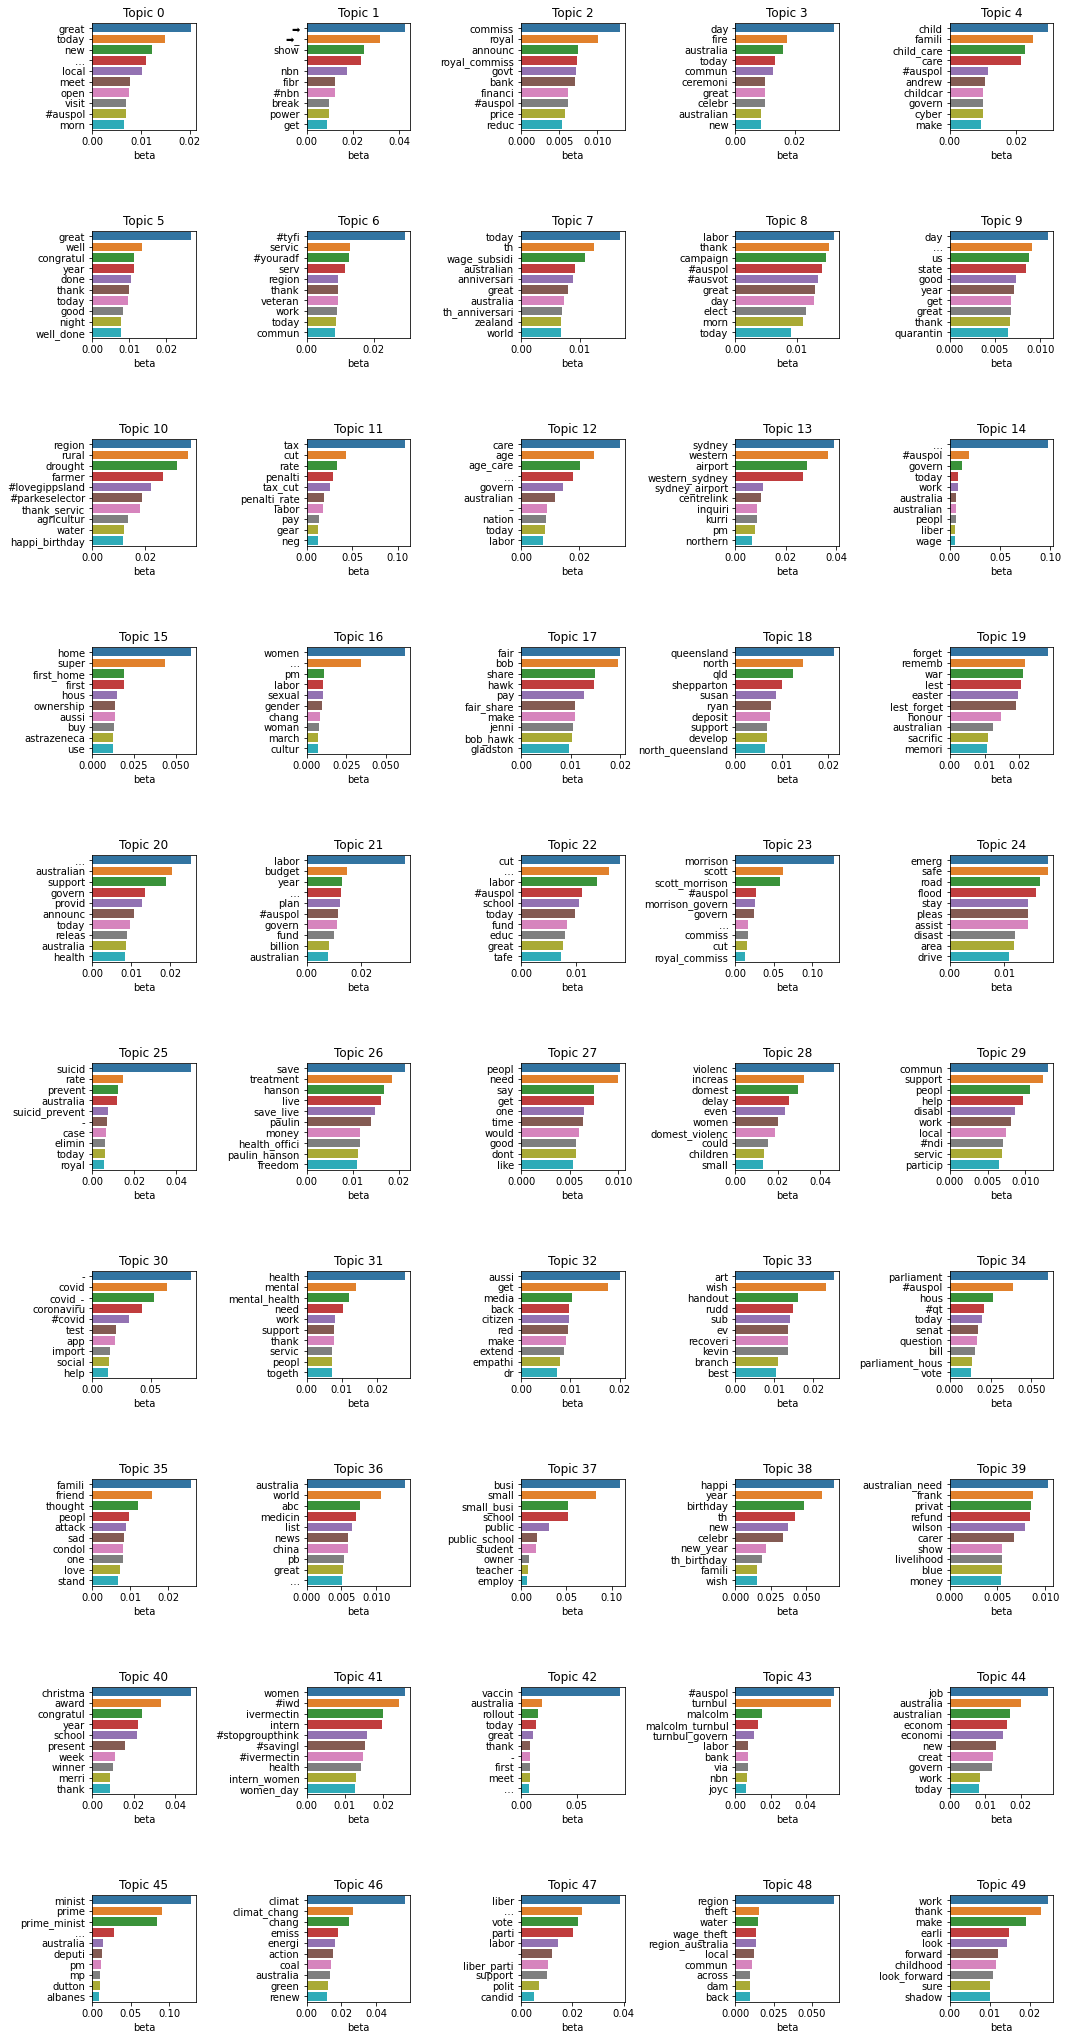

In [21]:
#Picking 20 topics to visualize
topics = list(range(0, 60))

fig, axes = plt.subplots(ncols=5, nrows=10, figsize = (16,30)) #Setting 20 subplots and determining figure size
fig.tight_layout(pad=8.0) #This ensure space between the subplots so the text can more easily be read
    
for ax, topic in zip(axes.flatten(), topics): #Iterates through the axes and the topics
    
    #Creates 50 barplots with x as the beta values and y as the words
    sns.barplot(ax = ax, 
                x = beta_df.iloc[topic].nlargest(10).values, 
                y = beta_df.iloc[topic].nlargest(10).index, 
                orient = 'h')
    
    ax.set(title='Topic {}'.format(topic), xlabel='beta')

plt.show()

In [16]:
#Insert the corpus of documents in bag of word format and get a list of (topic, probability) per document. 
document_topics = list(lda_model.get_document_topics(corpus)) 

#Creating a list of names for all 20 topics
topics = ['topic_{}'.format(t) for t in range(0,60)]

#Creating a dataframe of gamma probabilities 
gamma_probs = pd.DataFrame(np.zeros((len(document_topics),60)), columns = topics)

for i, doc in enumerate(document_topics): 
    for pair in doc: 
        gamma_probs.loc[i,'topic_{}'.format(pair[0])] = pair[1]

In [17]:
#Merging with the original dataframe 
gamma_df = pd.concat((tweets_agg,gamma_probs), axis = 1)

In [18]:
#Using regex to find all words and filter them from the weights
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(60,10)]

# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")

------ Topic 0 ------
great today new … local meet open visit #auspol morn

------ Topic 1 ------
➡ ➡_️ show ️ nbn fibr #nbn break power get

------ Topic 2 ------
commiss royal announc royal_commiss govt bank financi #auspol price reduc

------ Topic 3 ------
day fire australia today commun ceremoni great celebr australian new

------ Topic 4 ------
child famili child_care care #auspol andrew childcar govern cyber make

------ Topic 5 ------
great well congratul year done thank today good night well_done

------ Topic 6 ------
#tyfi servic #youradf serv region thank veteran work today commun

------ Topic 7 ------
today th wage_subsidi australian anniversari great australia th_anniversari zealand world

------ Topic 8 ------
labor thank campaign #auspol #ausvot great day elect morn today

------ Topic 9 ------
day … us state good year get great thank quarantin

------ Topic 10 ------
region rural drought farmer #lovegippsland #parkeselector thank_servic agricultur water happi_birthday

In [23]:
# Date object
gamma_df["created_at"] = pd.to_datetime(gamma_df["created_at"])

# We save this df
import os
gamma_df.to_csv('topic_models.csv')

In [ ]:
#Setting a theme
#sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
#plt.figure(figsize = (14,8))

#Choosing colors

#Plotting the covid topic for the full dataset
#sns.lineplot(x = 'date', y = 'topic_3', hue = 'p.party', data = gamma_df)

#plt.title('Topic of support over time (Topic 3)', fontsize = 16)
#plt.ylabel('Topic prevalence')
#plt.xlabel('created_at')

#plt.show()